### Import Packages

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.layers as layers
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix 

### Define key variables

In [2]:
filepath = '/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset'
test_size = 0.2
dev_size = 0.2
n_H = 102
n_W = 136
epochs = 30
learning_rate=0.0007
random.seed(6278)

### Import Data

Using the cv2 package, read in each file and append it to a normal list to create X data. For each file being read append the folder name which specifies the shoe_type label to Y variable.

As experienced later in development, not all images are of the specified 136x102 pixels so, in reading in the images, all will be resized with skimage to these dimensions such that they are of equal size later.

In [3]:
X = []
Y = []

for shoe_folder in os.scandir(filepath): # iterate through subfolders
    shoe_type = os.path.basename(shoe_folder) # Save folder name string for use as shoe label
    pbar = tqdm(os.scandir(shoe_folder.path), total=5000) # Use tqdm iter to display progress of reading in images
    
    for file in pbar: # iterate through files
        pbar.set_description(f"Processing {shoe_type} Images")
        img = cv2.imread(file.path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # transform defualt read in of cv2 BGR to RGB
        img_array = np.asarray(img)
        
        if img_array.shape != (102,136,3): # Do conditional resizing to save computing power
            img_array = resize(img_array, [n_H,n_W], anti_aliasing=True) # resize to ensure all images are 136 x 102
            
        X.append(img_array)
        Y.append(shoe_type)

Processing Boot Images: 100%|██████████| 5000/5000 [00:43<00:00, 115.24it/s]


In [4]:
X_Y = list(zip(X,Y)) # Zip images and associated label
random.shuffle(X_Y) # Shuffle
X, Y = zip(*X_Y) # Unzip back into X and Y

### Visualize shuffled images
Lets take a look at the first 20 images in the shuffled data.  Their Y label is used as the subplot title

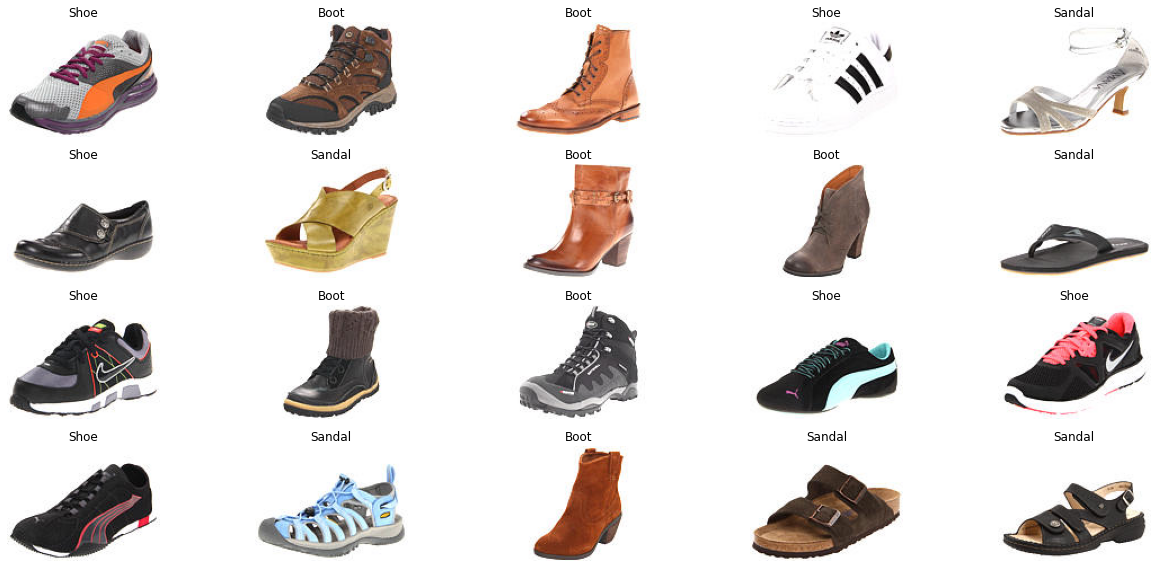

In [5]:
fig, axs = plt.subplots(4,5, figsize=[18,8])
for i in range(20):
    ax = axs[i//5, i%5]
    ax.imshow(X[i])
    ax.axis('off')
    ax.set_title(Y[i])
    
fig.tight_layout()
fig.show()

### Split Data into Train-Dev-Test
Steps:
* Convert list of nparray into singular nparrays
* One-Hot Encode Y-label
* Split into Train-Dev-Test
* Delete unused arrays to save on memory

In [6]:
num_dev = int(len(X) * dev_size) 
num_test = int(len(X) * test_size)

X_arr = np.asarray(X) / 255
Y_arr = np.asarray(Y).reshape(-1,1)

del X, Y

ohe = OneHotEncoder(categories='auto', sparse=False)
Y_ohe = ohe.fit_transform(Y_arr)

X_train = X_arr[:-(num_test + num_dev)]
X_dev = X_arr[-(num_test + num_dev):-num_test]
X_test = X_arr[-num_test:]

Y_train = Y_ohe[:-(num_test + num_dev)]
Y_dev = Y_ohe[-(num_test + num_dev):-num_test]
Y_test = Y_ohe[-num_test:]

del X_arr, Y_arr, Y_ohe

print("Training X:", X_train.shape)
print("Training Y:", Y_train.shape)
print("Development X:", X_dev.shape)
print("Development Y:", Y_dev.shape)
print("Test X:", X_test.shape)
print("Test Y:", Y_test.shape)

Training X: (9000, 102, 136, 3)
Training Y: (9000, 3)
Development X: (3000, 102, 136, 3)
Development Y: (3000, 3)
Test X: (3000, 102, 136, 3)
Test Y: (3000, 3)


### Building the Convolution Neural Network (Version 1)

This is my first attempt at a CNN for this problem.  I am using 3 Conv2D and 3 MaxPool layers alternated followed up by three Dense layers with the final layer being a softmax output. Additionally, I have added 3 Dropout Layers within the model to better assist with variance between train and test.

A key trait in my choices of Conv2D and MaxPool layers was to not lose any data at the edges of the image in the event the filter and stride would extend beyond the image.

In [7]:
model = tf.keras.Sequential(name = 'FirstModel')

model.add(layers.Conv2D(
    filters=8,
    kernel_size=7,
    activation='relu',
    strides=2,
    padding='same',
    input_shape=(n_H, n_W, 3),
    name='Conv1'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2),
    strides=None,
    padding='same',
    name='MaxPool1'))

model.add(layers.Conv2D(
    filters=16, 
    kernel_size=3, 
    activation='relu', 
    strides=1, 
    padding='valid',
    name='Conv2'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    name='MaxPool2'))

model.add(layers.Dropout(.2, name='Dropout1'))

model.add(layers.Conv2D(
    filters=32, 
    kernel_size=5, 
    activation='relu', 
    strides=1, 
    padding='same',
    name='Conv3'))

model.add(layers.MaxPool2D(
    pool_size=(2, 2), 
    strides=None,
    padding='valid',
    name='MaxPool3'))

model.add(layers.Flatten(name='Flatten'))

model.add(layers.Dropout(.2, name='Dropout2'))

model.add(layers.Dense(128,activation='relu',name='Dense1'))

model.add(layers.Dropout(.2, name='Dropout3'))

model.add(layers.Dense(32, activation='relu', name='Dense2'))

model.add(layers.Dense(3, activation='softmax', name='Dense3'))

model.summary()

2022-11-09 03:08:18.629143: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "FirstModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 51, 68, 8)         1184      
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 26, 34, 8)         0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 24, 32, 16)        1168      
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 12, 16, 16)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 12, 16, 16)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 12, 16, 32)        12832     
_________________________________________________________________
MaxPool3 (MaxPooling2D)      (None, 6, 8, 32)          0

I am using the Adam Optimizer with a set learning rate lower than default as it seemed the default was a little unstable in training.

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=epochs)

2022-11-09 03:08:26.926814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
282/282 [==============================] - 14s 45ms/step - loss: 0.4843 - accuracy: 0.7942 - val_loss: 0.2462 - val_accuracy: 0.9180
Epoch 2/30
282/282 [==============================] - 10s 37ms/step - loss: 0.2293 - accuracy: 0.9158 - val_loss: 0.1903 - val_accuracy: 0.9383
Epoch 3/30
282/282 [==============================] - 12s 41ms/step - loss: 0.1819 - accuracy: 0.9342 - val_loss: 0.1389 - val_accuracy: 0.9530
Epoch 4/30
282/282 [==============================] - 10s 37ms/step - loss: 0.1535 - accuracy: 0.9451 - val_loss: 0.1194 - val_accuracy: 0.9603
Epoch 5/30
282/282 [==============================] - 11s 38ms/step - loss: 0.1264 - accuracy: 0.9557 - val_loss: 0.0929 - val_accuracy: 0.9683
Epoch 6/30
282/282 [==============================] - 12s 41ms/step - loss: 0.1039 - accuracy: 0.9616 - val_loss: 0.1309 - val_accuracy: 0.9587
Epoch 7/30
282/282 [==============================] - 10s 35ms/step - loss: 0.0916 - accuracy: 0.9682 - val_loss: 0.0863 - val_accuracy:

### Summarize Results
Below you can see the training and validation losses over training. The Losses and Accuracies of the validation set were showing minimal improvement so there could have been more epochs of training if desired. The model is not overfitting the training data.

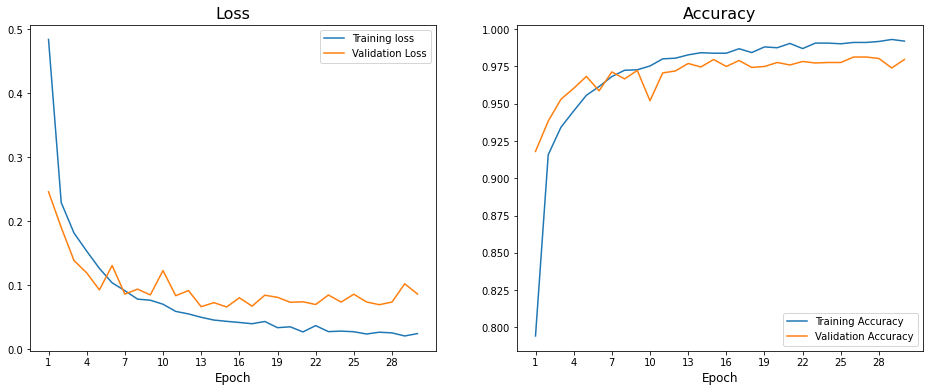

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1,epochs+1), history.history['loss'], label='Training loss')
ax1.plot(range(1,epochs+1), history.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1,epochs+1,3))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1,epochs+1), history.history['accuracy'], label='Training Accuracy')
ax2.plot(range(1,epochs+1), history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1,epochs+1,3))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);


The evaluation of the test data shows close results to the dev set as well, which is a good result.  Overall, on a train-dev-test 60/20/20 split, this model has achieved an **accuracy of 97.5%!**

In [10]:
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

94/94 [==============================] - 1s 15ms/step - loss: 0.0980 - accuracy: 0.9743
Test loss: 0.09797804802656174
Test accuracy: 0.9743333458900452


### Error Analysis
It is a good idea to examine what are examples of incorrectly labeled outputs to see if there is a certain characteristic of this input data that your model is performing poorly on. Below I will look a confusion matrix of the different outputs as well as a few of the incorrectly labeled results in the test set.

In [11]:
Y_pred = model.predict(X_test)
Y_pred_max = Y_pred.max(axis=1,keepdims=True)
Y_pred = (Y_pred_max == Y_pred).astype(int)
Y_test_labels = ohe.inverse_transform(Y_test)
Y_pred_labels = ohe.inverse_transform(Y_pred)

,Shoe_pred,Sandal_pred,Boot_pred
Shoe_true,98.041045,0.746269,1.212687
Sandal_true,3.549061,95.824635,0.626305
Boot_true,0.721649,0.927835,98.350515


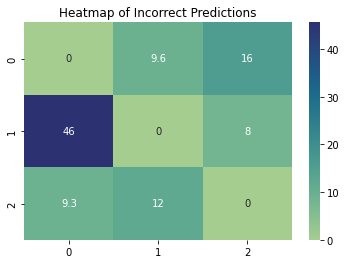

In [12]:
labels = labels=["Shoe", "Sandal", "Boot"]
cm = confusion_matrix(Y_test_labels, Y_pred_labels, labels=labels, normalize='true') * 100



CM = pd.DataFrame(cm,
                  columns = [label+'_pred' for label in labels],
                  index = [label+'_true' for label in labels]).copy()

np.fill_diagonal(cm, 0)
cm = cm *100 / cm.sum()
sns.heatmap(cm, annot=True, cmap="crest")
plt.title('Heatmap of Incorrect Predictions')

CM


Over 40% of the incorrect guesses are coming from the model incorrectly predicting sandals as shoes. For further improvement to the model, I would focus on what is causing this discrepancy

In [13]:
prediction_df = pd.DataFrame(zip(Y_pred_labels[:,0], Y_test_labels[:,0]), columns=['Pred', 'True'])
prediction_df['Correct'] = prediction_df['Pred'] == prediction_df['True']
incorrect_predictions = list(prediction_df[prediction_df['Correct'] == False].index)

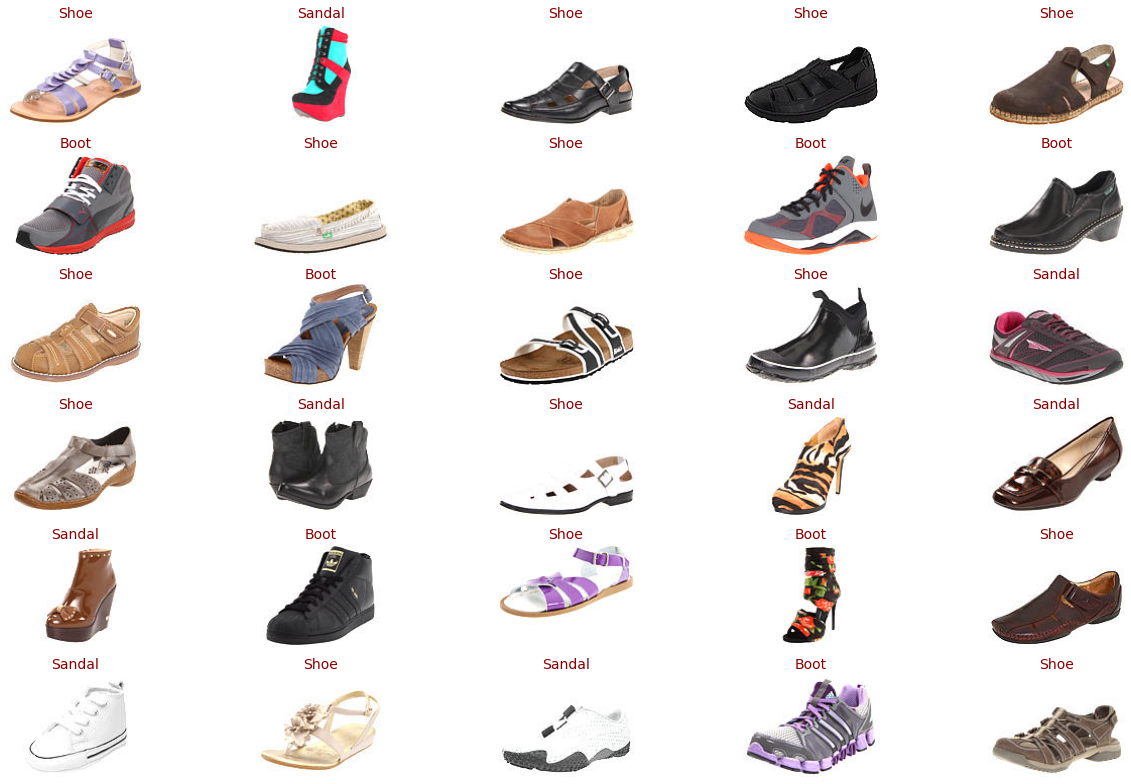

In [14]:
fig, axs = plt.subplots(6,5, figsize=[18,11])
for i, inpred in enumerate(incorrect_predictions[:30]):
    ax = axs[i//5, i%5]
    ax.imshow(X_test[inpred])
    ax.axis('off')
    ax.set_title(Y_pred_labels[inpred][0], fontsize=14, color="darkred")
    
fig.tight_layout()
fig.show()

### Error Analysis

Looking at this subsample of incorrectly predict labels, there seems to be a few trends:
* Incorrectly labeling sandals as shoes when there is a lot of material that covers the top of the foot
* Incorrectly labeling as boots for any shoe or sandal with high tops
* Incorrectly labeling as sandals when either design or laces has appears as thick stripes across top.